In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 365

In [153]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [154]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet on df_train для проверки модели

In [155]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

01:38:26 - cmdstanpy - INFO - Chain [1] start processing
01:38:27 - cmdstanpy - INFO - Chain [1] done processing


In [156]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [157]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2649,2024-01-10,11.586209,9.121303,14.082038
2650,2024-01-11,11.576706,9.008230,14.048291
2651,2024-01-12,11.583587,9.198598,14.071049
2652,2024-01-13,12.389931,9.989149,14.862835
2653,2024-01-14,12.407272,9.933595,14.900682


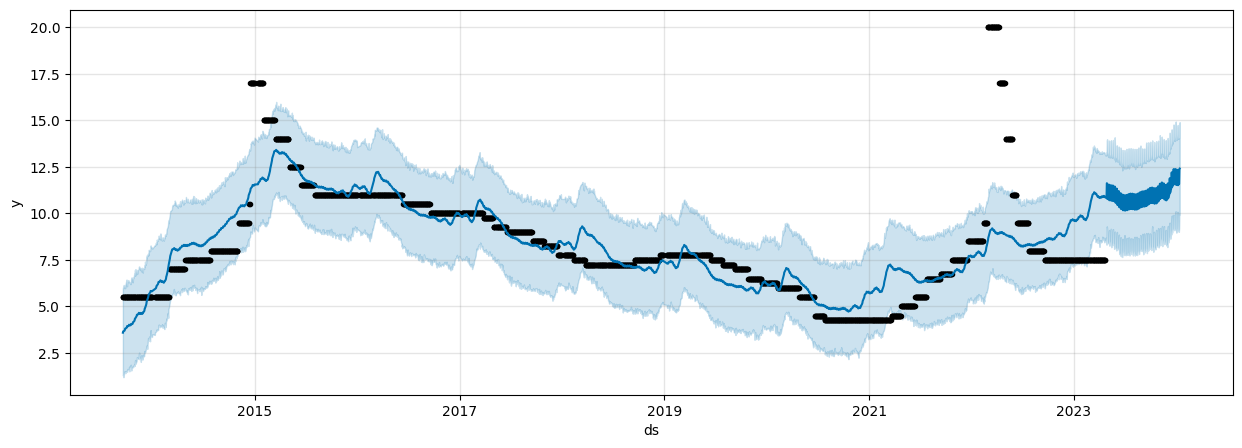

In [158]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

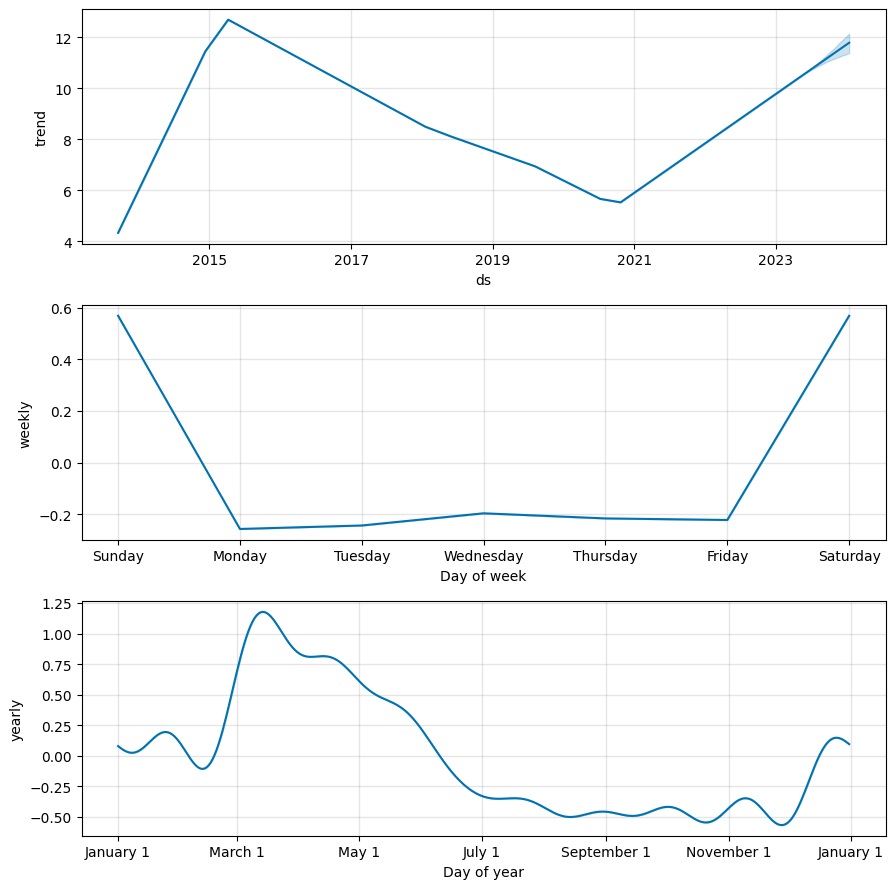

In [159]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [160]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-05-03,12.713166,10.421733,15.359342
261,2024-05-06,12.652477,10.164133,15.085844
262,2024-05-07,12.659267,10.121614,14.976794
263,2024-05-08,12.700815,10.175074,15.050915
264,2024-05-10,12.666301,10.052286,15.246653


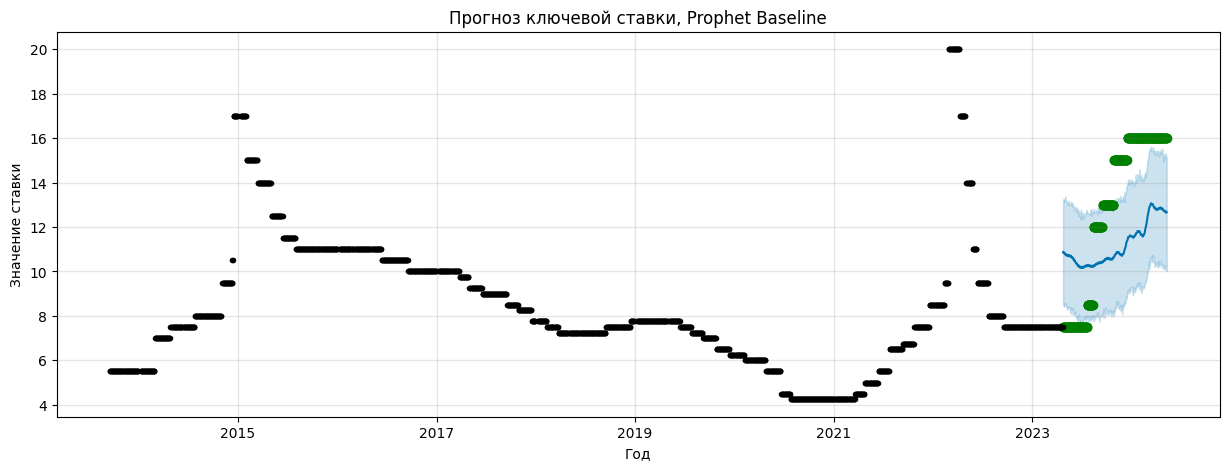

In [161]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

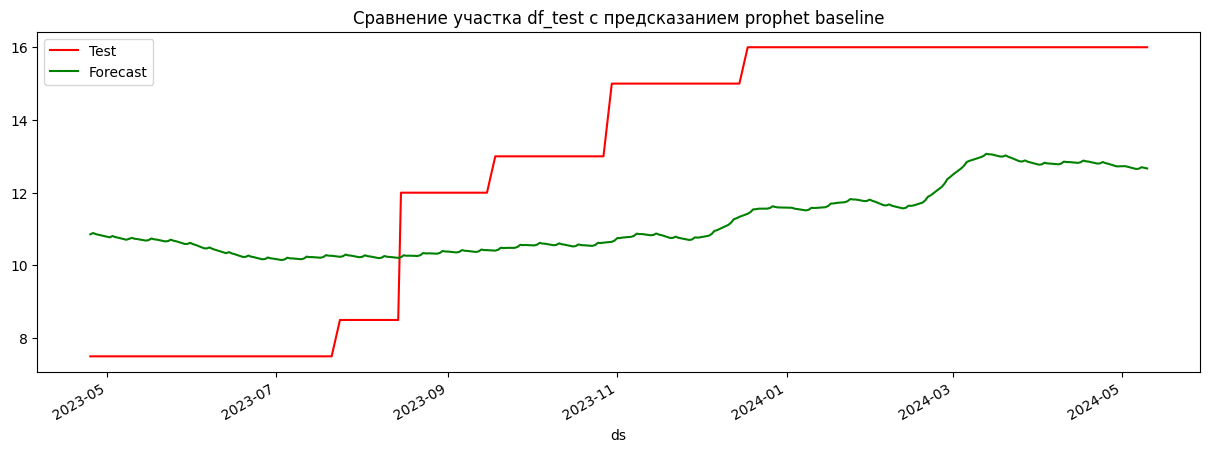

In [162]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [163]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.160319,0.261074,10.78128,3.283486


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [164]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [165]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

01:38:30 - cmdstanpy - INFO - Chain [1] start processing
01:38:31 - cmdstanpy - INFO - Chain [1] done processing


In [166]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2649,2024-01-10,11.682622,9.380529,14.297631
2650,2024-01-11,11.663057,9.183228,14.080367
2651,2024-01-12,11.668467,9.273687,14.055052
2652,2024-01-13,12.425719,10.009803,14.909265
2653,2024-01-14,12.435325,10.042311,14.805111


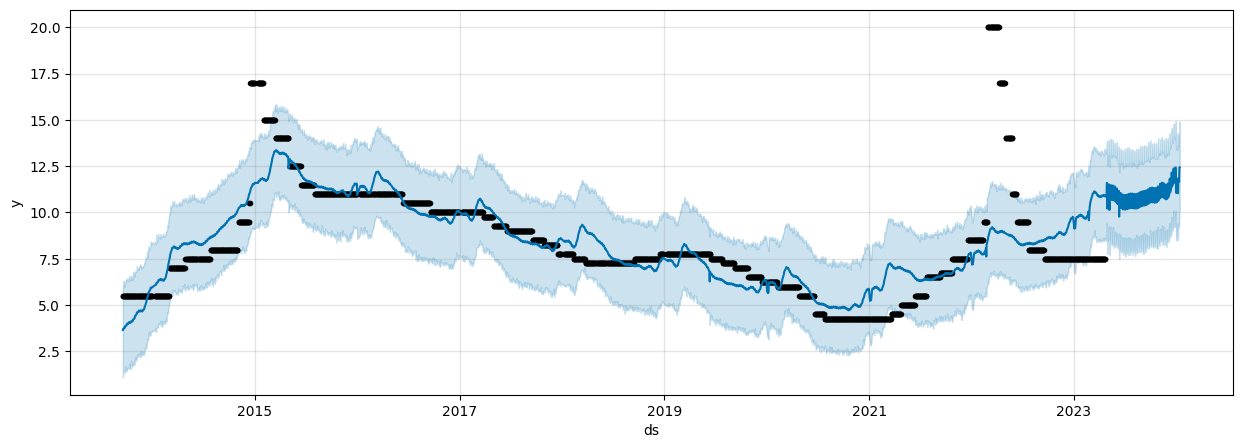

In [167]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

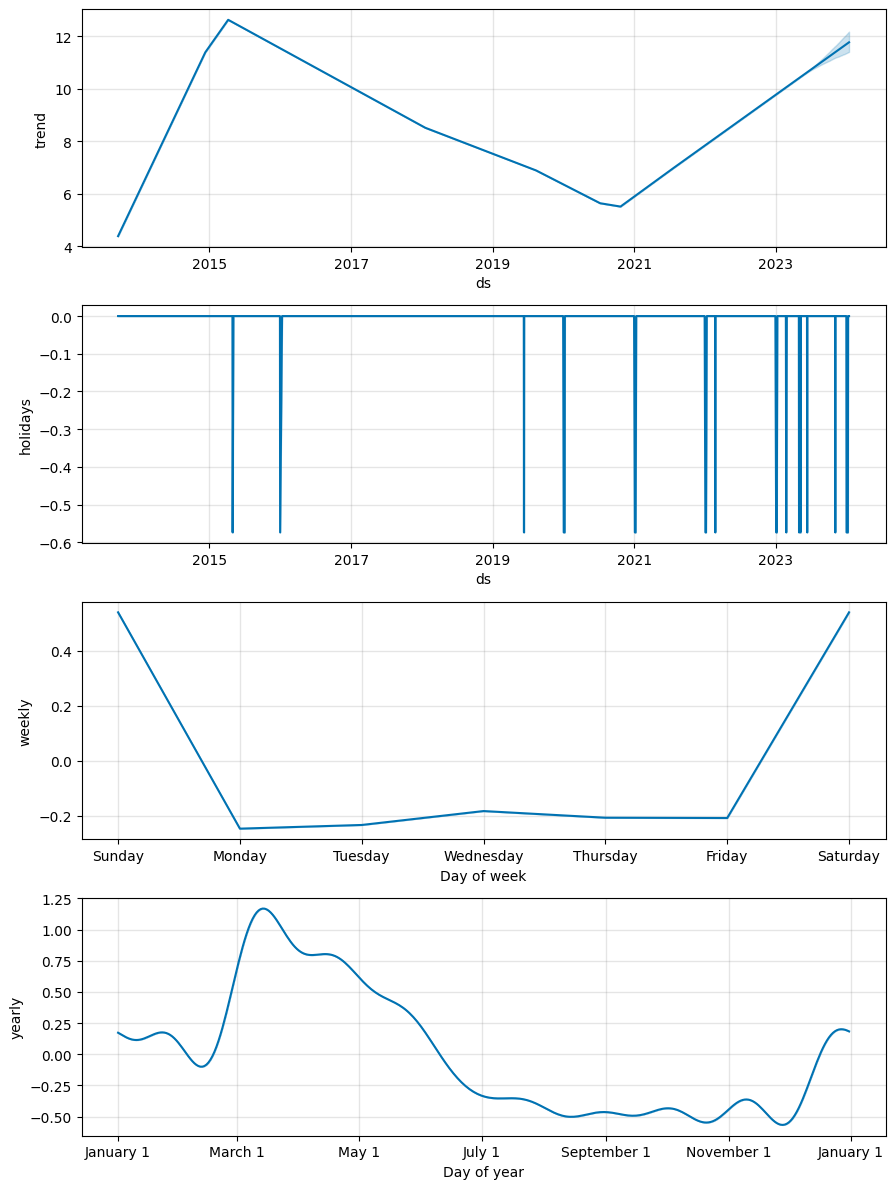

In [168]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [169]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-05-03,12.724070,10.282092,15.240433
261,2024-05-06,12.655537,9.988728,15.059096
262,2024-05-07,12.660827,10.081203,15.238243
263,2024-05-08,12.704320,10.219830,15.306950
264,2024-05-10,12.667468,10.273437,15.258481


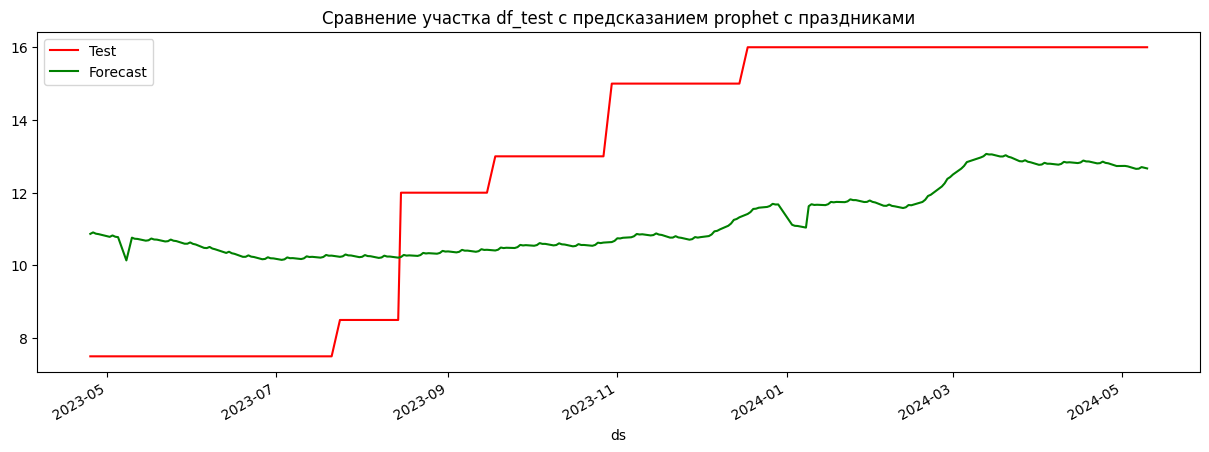

In [170]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [171]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.160319,0.261074,10.781280,3.283486
0,Prophet_with_holidays,3.163750,0.261244,10.818029,3.289077


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [172]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [173]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]01:38:35 - cmdstanpy - INFO - Chain [1] start processing
01:38:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<09:35,  1.17it/s]01:38:35 - cmdstanpy - INFO - Chain [1] start processing
01:38:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<09:51,  1.13it/s]01:38:36 - cmdstanpy - INFO - Chain [1] start processing
01:38:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:02<10:20,  1.08it/s]01:38:37 - cmdstanpy - INFO - Chain [1] start processing
01:38:37 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:03<10:03,  1.11it/s]01:38:38 - cmdstanpy - INFO - Chain [1] start processing
01:38:38 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:04<09:49,  1.13it/s]01:38:39 - cmdstanpy - INFO - Chain [1] start processing
01:38:39 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:05<09:38,  1.15it/s]0

In [174]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [175]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.801883,0.394175,47.334063,6.879976,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.973391,0.408078,49.656166,7.046713,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.934425,0.405272,49.052038,7.003716,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.918259,0.404155,48.792875,6.985190,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.927413,0.403814,49.145887,7.010413,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.670943,0.991400,281.030681,16.763970,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.518244,0.333455,25.101856,5.010175,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.616147,0.339712,26.317024,5.130012,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.674199,0.342402,27.193098,5.214700,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [176]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.645719,0.297619,14.764682,3.842484,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,Prophet_with_grid,3.645719,0.297619,14.764682,3.842484,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,Prophet_with_grid,3.645719,0.297619,14.764682,3.842484,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,Prophet_with_grid,3.645719,0.297619,14.764682,3.842484,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,Prophet_with_grid,3.661177,0.298142,14.874736,3.856778,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [177]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [178]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

01:56:01 - cmdstanpy - INFO - Chain [1] start processing
01:56:02 - cmdstanpy - INFO - Chain [1] done processing


In [179]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2649,2024-01-10,11.586209,9.200913,13.892351
2650,2024-01-11,11.576706,9.077318,14.000004
2651,2024-01-12,11.583587,9.148621,13.888079
2652,2024-01-13,12.389931,10.027316,14.689127
2653,2024-01-14,12.407272,9.945750,14.880443


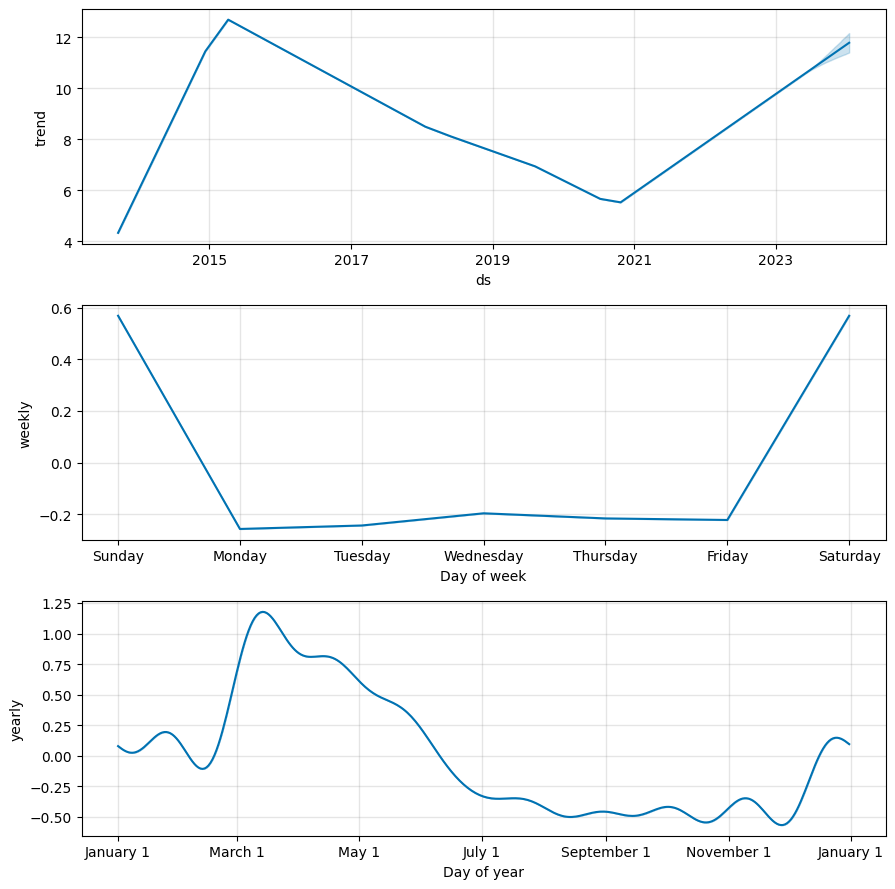

In [180]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

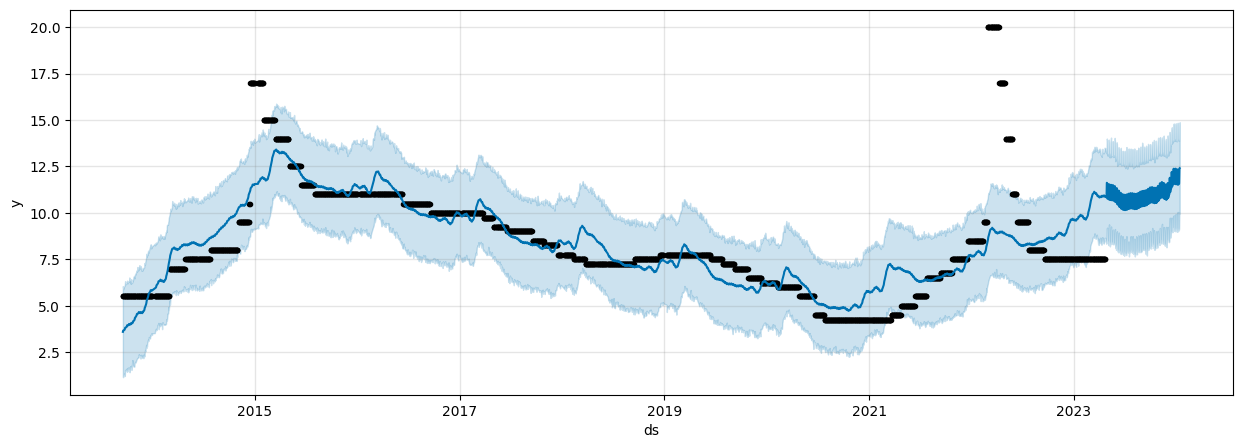

In [181]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [182]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
260,2024-05-03,12.713166,10.286159,15.067940
261,2024-05-06,12.652477,10.344972,15.167638
262,2024-05-07,12.659267,10.032194,15.288453
263,2024-05-08,12.700815,10.258517,15.234775
264,2024-05-10,12.666301,10.161775,15.272089


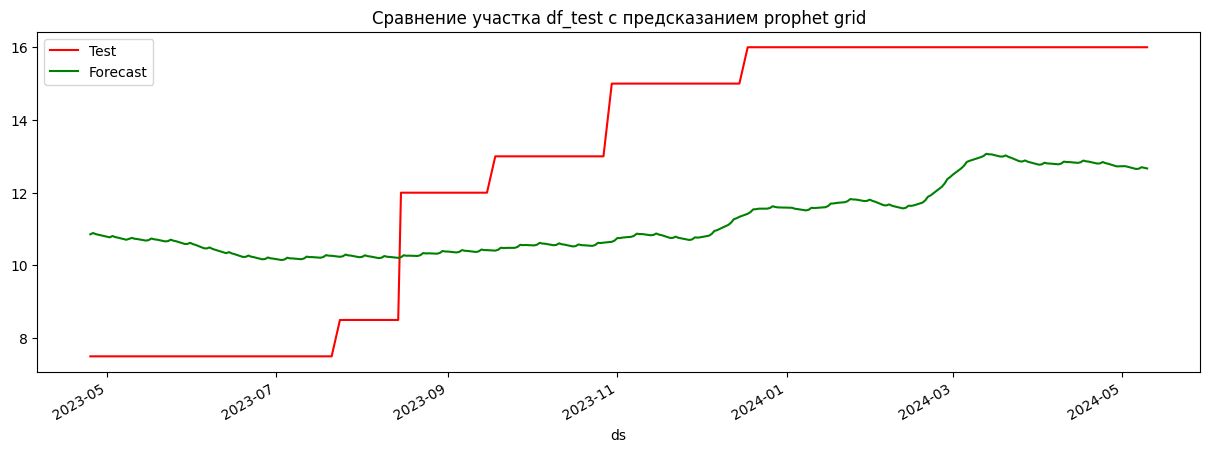

In [183]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [184]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.160319,0.261074,10.781280,3.283486
0,Prophet_with_holidays,3.163750,0.261244,10.818029,3.289077
0,Prophet_with_grid,3.160319,0.261074,10.781280,3.283486


In [185]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [186]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.195% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.
Missing logger folder: d:\Dropbox\Develop\Phyton Projects\MyProject\01_Prediction of the key rate i

Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [187]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.195% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.604% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.604% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 38it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
260,2024-05-03,16.0,11.881945,14.678076,0.434466,-3.230597
261,2024-05-06,16.0,11.904907,14.693809,0.468275,-3.257176
262,2024-05-07,16.0,11.923758,14.699055,0.478352,-3.253649
263,2024-05-08,16.0,11.979959,14.704299,0.487708,-3.212048
264,2024-05-10,16.0,11.985847,14.714787,0.504041,-3.232980


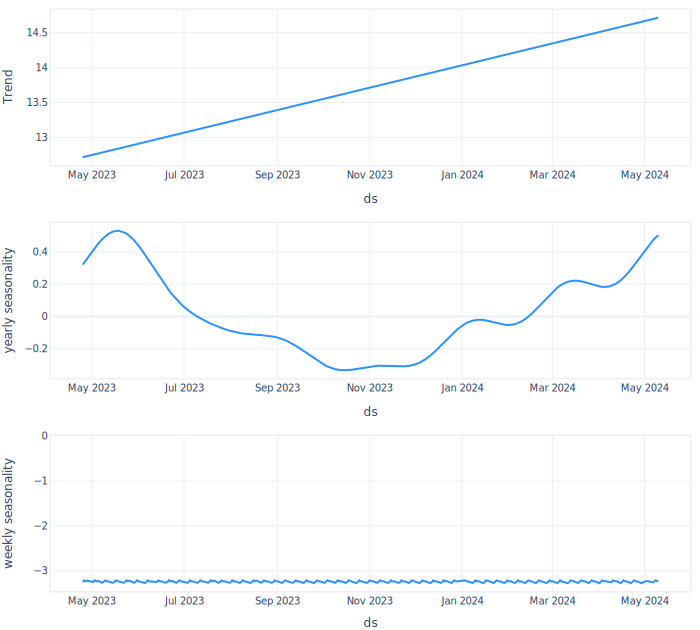

In [188]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl)

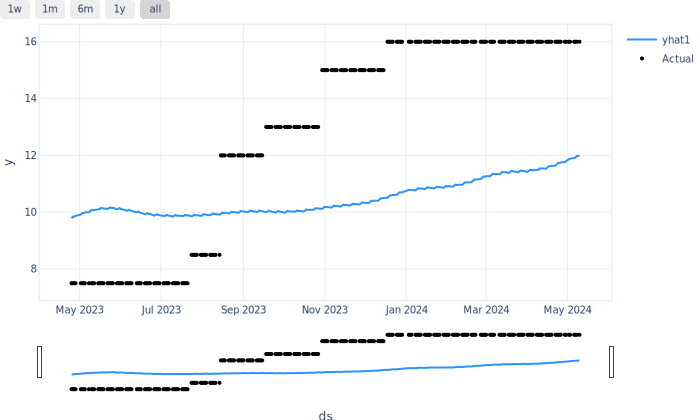

In [189]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax)

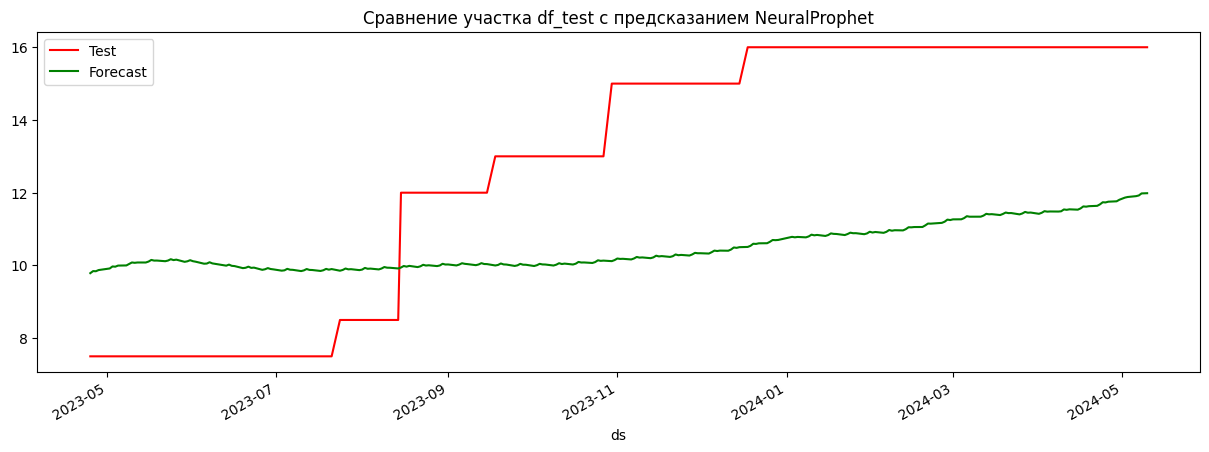

In [190]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [191]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.160319,0.261074,10.781280,3.283486
0,Prophet_with_holidays,3.163750,0.261244,10.818029,3.289077
0,Prophet_with_grid,3.160319,0.261074,10.781280,3.283486
0,NeuralProphet,3.584669,0.280375,14.464373,3.803206


# Обучение и прогнозирование курса на df

# Prophet baseline on df

In [192]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

01:56:39 - cmdstanpy - INFO - Chain [1] start processing
01:56:40 - cmdstanpy - INFO - Chain [1] done processing


In [193]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3014,2025-05-06,15.910522,13.316337,18.659924
3015,2025-05-07,15.919352,13.409898,18.701685
3016,2025-05-08,15.878163,13.200100,18.476883
3017,2025-05-09,15.846053,13.327130,18.464912
3018,2025-05-10,16.619972,14.027306,19.272631


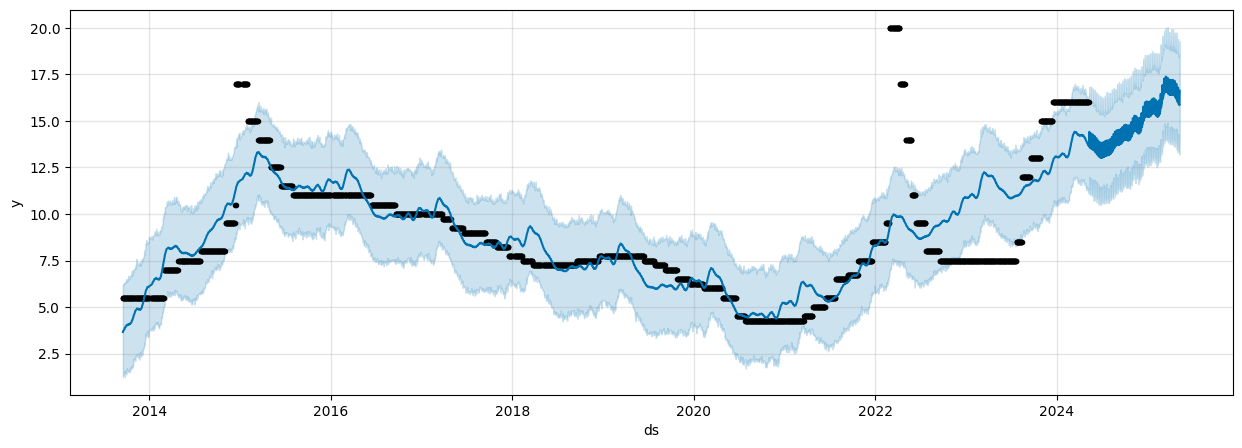

In [194]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

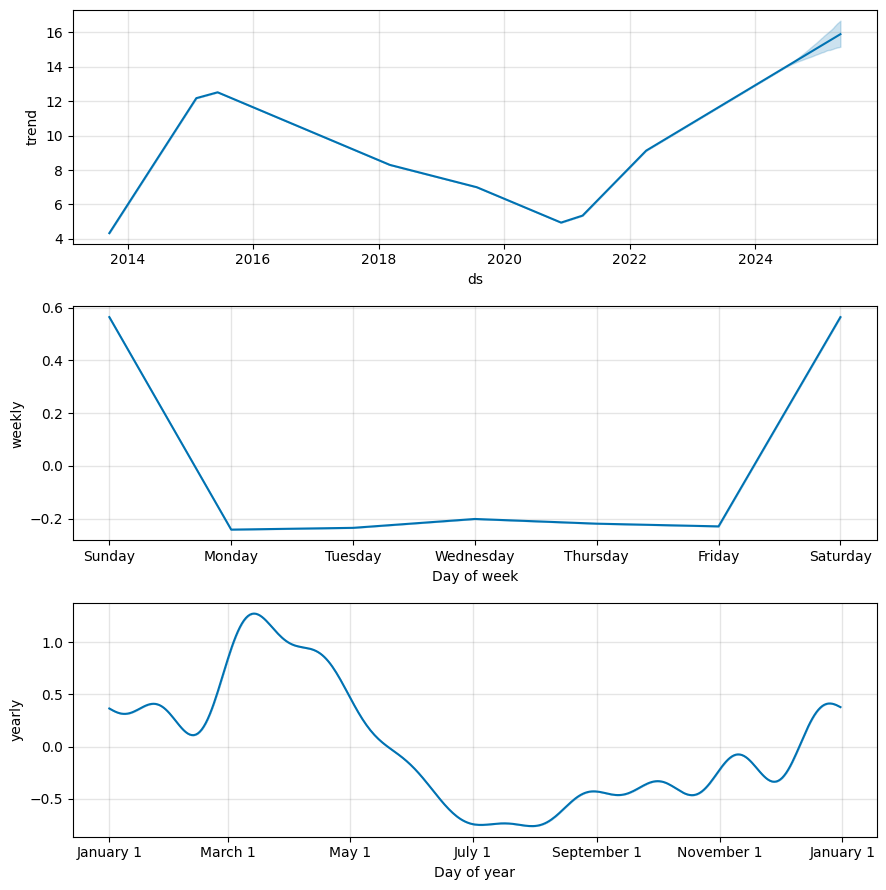

In [195]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [196]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

01:56:43 - cmdstanpy - INFO - Chain [1] start processing
01:56:43 - cmdstanpy - INFO - Chain [1] done processing


In [197]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3014,2025-05-06,15.910522,13.279913,18.707946
3015,2025-05-07,15.919352,13.189649,18.681134
3016,2025-05-08,15.878163,13.381356,18.407118
3017,2025-05-09,15.846053,13.207788,18.618764
3018,2025-05-10,16.619972,14.121889,19.292910


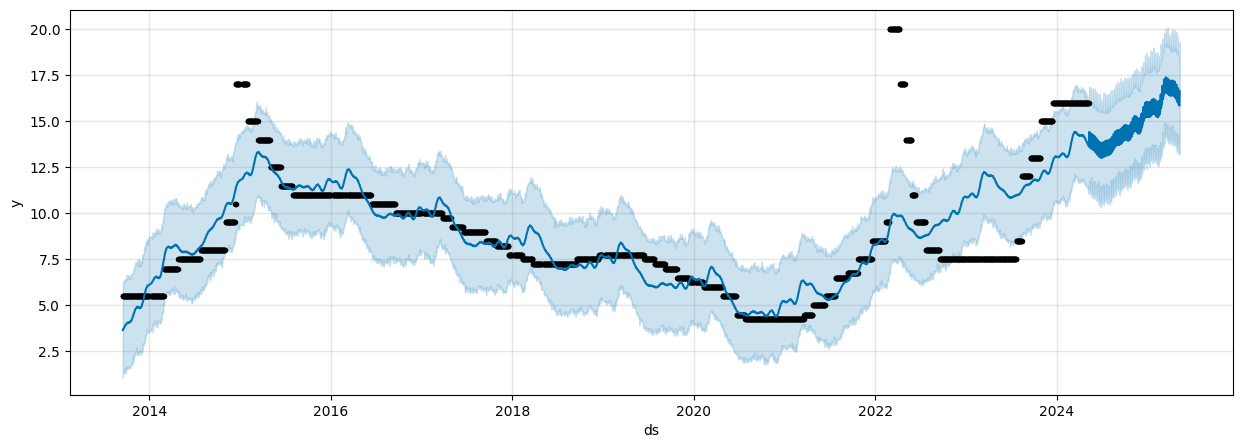

In [198]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

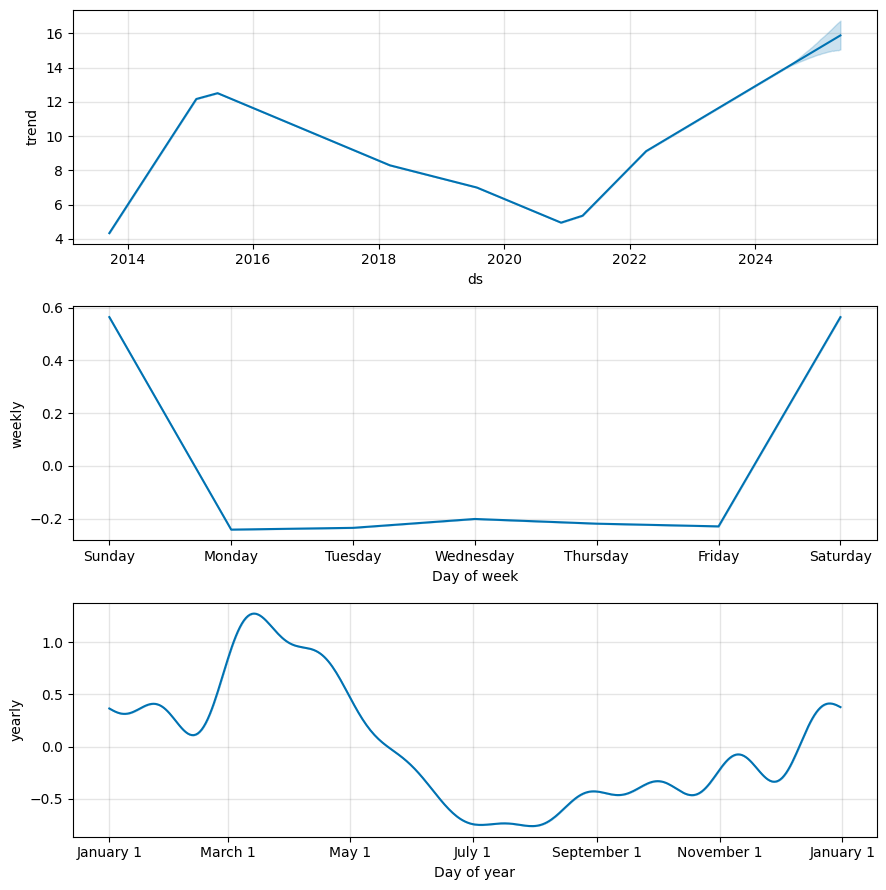

In [199]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [217]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.174% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (42) is too small than the required number                     for the learning rate finder (235). The results might not be optimal.


Finding best initial lr:   0%|          | 0/235 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [228]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.174% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.427% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.427% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 261 rows at the end with NaNs in 'y' column.


Predicting: 42it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2910,2025-05-06,NaN,17.243319,6.354532,0.304607,10.584179
2911,2025-05-07,NaN,17.250469,6.362603,0.292943,10.594923
2912,2025-05-08,NaN,17.213978,6.370677,0.280723,10.562580
2913,2025-05-09,NaN,17.195597,6.378750,0.267915,10.548931
2914,2025-05-12,NaN,17.169882,6.402971,0.226489,10.540421


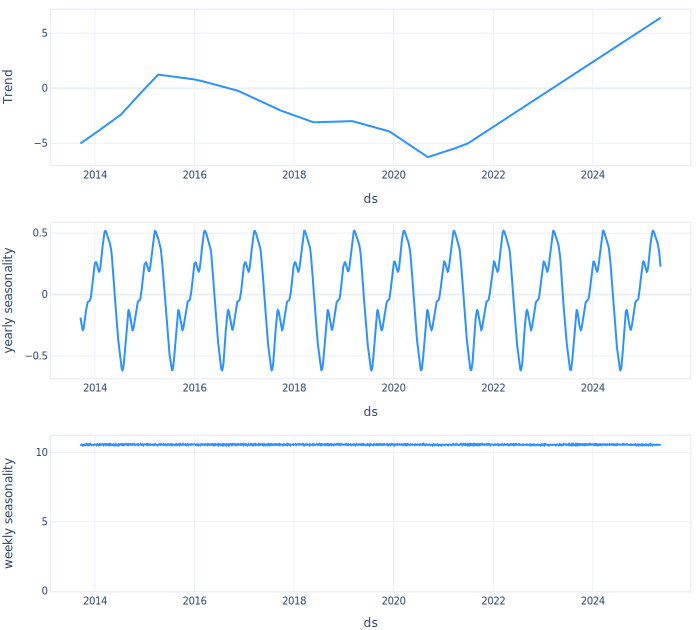

In [229]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np)

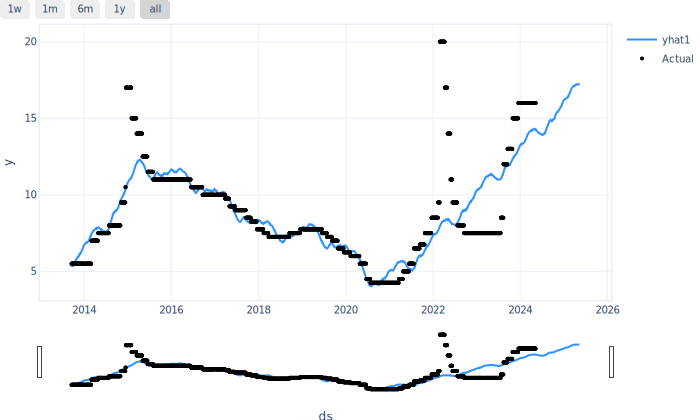

In [230]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np)

# Сравнение прогнозов обученных моделей

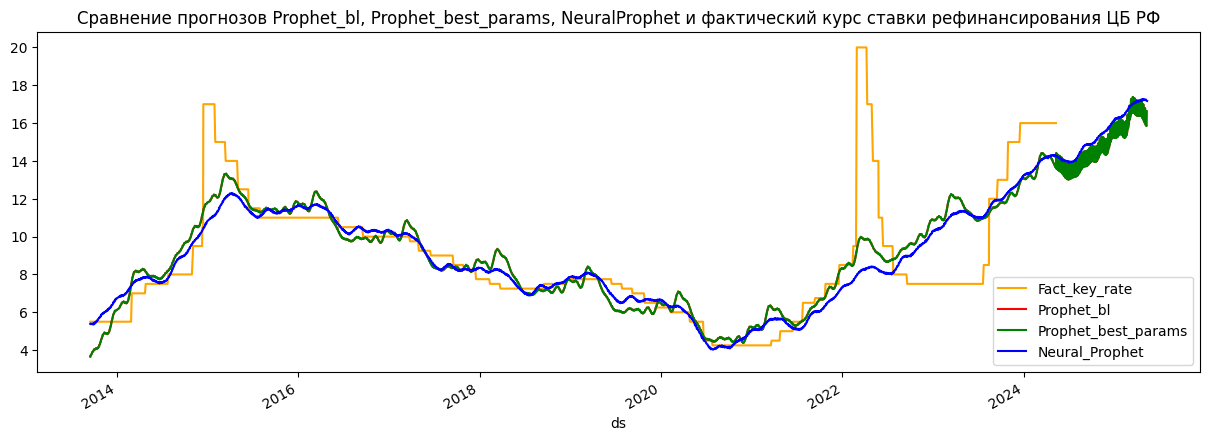

In [231]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.